In [1]:
cd ../

c:\Users\eduar\Documents\usp\AMST\ml_timeseries_usp


In [2]:
from src.data.make_dataset import DatasetCreator
from src.data.make_hierarchical_dataset import DatasetHierarchicalAggregator
from src.data.refine_dataset import HierarchicalTimeSeriesOutlierRemover
from src.data.split import hierarchical_train_test_split
from src.features.build_features import FeaturesBuilder
from src.config import load_config
#from src.models.tuning import HierarchicalTuning

config = load_config()

df = DatasetCreator(config).run()

if config['exogen_features'] == 'true':
    df = FeaturesBuilder(df,config).run()
else:
    pass

Y_df,S_df,tags = DatasetHierarchicalAggregator(config,df).run()

train,test = hierarchical_train_test_split(Y_df)

2025-11-28 14:35:34,004 - INFO - Config carregado de c:\Users\eduar\Documents\usp\AMST\ml_timeseries_usp\config.yaml
2025-11-28 14:35:34,057 - INFO - Config carregado de c:\Users\eduar\Documents\usp\AMST\ml_timeseries_usp\config.yaml


Filtrando nível: ['total', 'centro_distribuicao'] (>= 42 obs)
   → 3 combinações → 3 mantidas (100.0%)
Filtrando nível: ['total'] (>= 42 obs)
   → 1 combinações → 1 mantidas (100.0%)


2025-11-28 14:36:32,835 - INFO - Agregação hierárquica concluída.


tags salvo com joblib → 100% fiel ao original
Tamanho: 0.4 KB
Train: 2022-01-01 → 2025-01-01 (37 meses)
Test (backtest): 2025-02-01 → 2025-07-01 (6 meses)


In [8]:

from utils import read_all_csv_files
from utils import (
    read_all_csv_files,
    correcting_dtypes,
    stocks_removing_negatives,
    remove_materials_no_sales,
    plot_time_series_by_products,
    plot_products_materials,
    plot_produtos_in_cds,
    plot_time_series_cds_products_by_stores,
    plot_time_series_cds_products_by_store_size,
    plot_time_series_cds_products_by_store_weather,
    plot_time_series_cds_products_by_store_profile,
    plot_time_series_cds_products_store_region,
    violin_plot_material_store_sales,
    ajustes_preco_features,
    droping_and_replace_prices,
    hierarchical_aggregation,
    remover_dados_duplicados_estoque,
    fillna_hierarchical,
    ajustar_decotes,

    remove_time_series_min_length
    )
import pandas as pd
import seaborn as sns
from statsforecast import StatsForecast
from statsforecast.models import MSTL,AutoETS,AutoARIMA,SeasonalExponentialSmoothing
from hierarchicalforecast.methods import BottomUp
from statsmodels.graphics.tsaplots import plot_acf
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import evaluate
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss,rmsse
from functools import partial
from prophet import Prophet
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np
import xgboost as xgb
import aeon
import lightgbm as lgbm

In [3]:
def data_preparation():
    #data preparation
    df = read_all_csv_files('data/raw')
    df = correcting_dtypes(df)
    df = stocks_removing_negatives(df)
    df = ajustes_preco_features(df)
    #df = droping_and_replace_prices(df)
    # === USO ===
    hierarchy = [
        ['material', 'loja', 'mes'],     # mais específico
        ['produto', 'loja', 'mes'],
        ['material', 'mes'],
        ['produto', 'mes'],
        ['material'],
        ['produto']
    ]

    #df = fillna_hierarchical(df, 'preco_unitario', hierarchy, agg_func='median')
    df = ajustar_decotes(df)
    #df = remover_dados_duplicados_estoque(df)
    df = remove_materials_no_sales(df)
    df = remove_time_series_min_length(df, min_length=24)

    spec = [
        ['total'],
        ['total','centro_distribuicao'],
        ['total','centro_distribuicao','loja'],
        #['total','centro_distribuicao','regiao_loja','clima_loja'],
        #['total','centro_distribuicao','regiao_loja','clima_loja','loja'],
        #['total','centro_distribuicao','regiao_loja','clima_loja','loja','produto'],
        #['total','centro_distribuicao','regiao_loja','clima_loja','loja','produto','material'],
        #['total','centro_distribuicao','regiao_loja','clima_loja','loja','produto','material','sku']
]

    Y_df, S_df, tags = hierarchical_aggregation(df, spec, columns = ['centro_distribuicao','regiao_loja','clima_loja','loja','produto','material','sku','mes','venda_unidades'], ds='mes', y='venda_unidades',exog=['estoque_unidades_inicio'])
    Y_df['unique_id'] = Y_df['unique_id'].astype('category')
    return Y_df, S_df, tags

In [4]:
def hierarchical_aggregation(df, spec, columns=None, ds='mes', y='venda_unidades',exog=None):
    if columns:
        if exog:
            df_h = df[columns+exog].copy()
        else:
            df_h = df[columns].copy()
    df_h = df_h.dropna()
    df_h = df_h.rename(columns={ds: 'ds', y: 'y'})
    df_h['total'] = 'total'
    df_h['ds'] = pd.to_datetime(df_h['ds'])
    df_h = df_h.sort_values('ds')
    print(df_h.columns)

    if exog:
        y_hier, S, tags = aggregate(
            df=df_h,
            spec=spec,
            exog_vars={'estoque_unidades_inicio': 'sum'}
            
    )
    else:
        y_hier, S, tags = aggregate(
            df=df_h,
            spec=spec
    )
    print(y_hier.columns)
    print("Níveis criados:")
    for k, v in tags.items():
        print(f"{k}: {len(v)} séries")
    return y_hier, S, tags

In [5]:
Y_df, S_df, tags = data_preparation()

TypeError: read_csv_files() takes 1 positional argument but 2 were given

In [7]:
Y_df

,unique_id,ds,y
0,total,2022-01-01,24816
1,total,2022-02-01,27690
2,total,2022-03-01,20979
3,total,2022-04-01,16943
4,total,2022-05-01,16950
...,...,...,...
167,total/CD3,2025-03-01,4250
168,total/CD3,2025-04-01,4207
169,total/CD3,2025-05-01,4737
170,total/CD3,2025-06-01,4476


In [ ]:
[var for var in exog_vars.keys() if var not in df.columns]

In [155]:
df_ = Y_df[Y_df['unique_id']=='total']

In [156]:
def train_valid_split(df):
    horizon = 6
    valid = df.groupby('unique_id').tail(horizon)
    train = df.drop(valid.index)
    return train, valid

In [157]:
train,valid = train_valid_split(df_)

C:\Users\eduar\AppData\Local\Temp\ipykernel_22816\35886996.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid = df.groupby('unique_id').tail(horizon)


In [87]:
def create_exog_lags(train):# Defina lags e transforms para o ESTOQUE (exógena)
    exog_lags = [0, 1, 2, 3, 6, 12]  # 0=valor atual (essencial!), 1=mês anterior, etc.
    exog_lag_transforms = {
        0: [ExpandingMean()],           # Média histórica até o mês atual
        1: [RollingMean(3), RollingMean(6)],  # Suavização recente
        2: [RollingMean(3)],
        3: [RollingMean(3)],
        6: [RollingMean(3)],
        12: [RollingMean(3)]            # Sazonal (12 meses)
    }

    # Aplique no train (cria novas colunas com lags/transforms)
    train_with_lags = transform_exog(
        df=train,
        lags=exog_lags,
        lag_transforms=exog_lag_transforms,
        id_col='unique_id',    # ID das séries hierárquicas
        time_col='ds',         # Coluna de tempo
        num_threads=4          # Acelera (ajuste para sua CPU)
    )
    return train_with_lags

In [88]:
create_exog_lags(train)

,unique_id,ds,y,estoque_unidades_inicio_sum,y_lag0,y_lag1,y_lag2,y_lag3,y_lag6,y_lag12,...,estoque_unidades_inicio_sum_lag3,estoque_unidades_inicio_sum_lag6,estoque_unidades_inicio_sum_lag12,estoque_unidades_inicio_sum_expanding_mean_lag0,estoque_unidades_inicio_sum_rolling_mean_lag1_window_size3,estoque_unidades_inicio_sum_rolling_mean_lag1_window_size6,estoque_unidades_inicio_sum_rolling_mean_lag2_window_size3,estoque_unidades_inicio_sum_rolling_mean_lag3_window_size3,estoque_unidades_inicio_sum_rolling_mean_lag6_window_size3,estoque_unidades_inicio_sum_rolling_mean_lag12_window_size3
0,total,2022-01-01,25907.0,43145.0,25907.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,43145.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,total,2022-02-01,31508.0,39860.0,31508.0,25907.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,41502.500000,NaN,NaN,NaN,NaN,NaN,NaN
2,total,2022-03-01,26458.0,35377.0,26458.0,31508.0,25907.0,NaN,NaN,NaN,...,NaN,NaN,NaN,39460.666667,NaN,NaN,NaN,NaN,NaN,NaN
3,total,2022-04-01,20519.0,30773.0,20519.0,26458.0,31508.0,25907.0,NaN,NaN,...,43145.0,NaN,NaN,37288.750000,39460.666667,NaN,NaN,NaN,NaN,NaN
4,total,2022-05-01,19704.0,24585.0,19704.0,20519.0,26458.0,31508.0,NaN,NaN,...,39860.0,NaN,NaN,34748.000000,35336.666667,NaN,39460.666667,NaN,NaN,NaN
5,total,2022-06-01,20847.0,25222.0,20847.0,19704.0,20519.0,26458.0,NaN,NaN,...,35377.0,NaN,NaN,33160.333333,30245.000000,NaN,35336.666667,39460.666667,NaN,NaN
6,total,2022-07-01,19627.0,30535.0,19627.0,20847.0,19704.0,20519.0,25907.0,NaN,...,30773.0,43145.0,NaN,32785.285714,26860.000000,33160.333333,30245.000000,35336.666667,NaN,NaN
7,total,2022-08-01,16786.0,23581.0,16786.0,19627.0,20847.0,19704.0,31508.0,NaN,...,24585.0,39860.0,NaN,31634.750000,26780.666667,31058.666667,26860.000000,30245.000000,NaN,NaN
8,total,2022-09-01,21766.0,29488.0,21766.0,16786.0,19627.0,20847.0,26458.0,NaN,...,25222.0,35377.0,NaN,31396.222222,26446.000000,28345.500000,26780.666667,26860.000000,39460.666667,NaN
9,total,2022-10-01,29380.0,43039.0,29380.0,21766.0,16786.0,19627.0,20519.0,NaN,...,30535.0,30773.0,NaN,32560.500000,27868.000000,27364.000000,26446.000000,26780.666667,35336.666667,NaN


In [13]:
for n in range(3, 12,3):
    print(n)

3
6
9


In [6]:
from mlforecast.target_transforms import Differences, LocalBoxCox, LocalStandardScaler
from mlforecast.lag_transforms import ExpandingMean,RollingMean
from mlforecast import MLForecast

from utilsforecast.plotting import plot_series
from mlforecast.utils import PredictionIntervals
import optuna
from mlforecast.optimization import mlforecast_objective
import lightgbm as lgbm 

In [18]:
[n for n in range(1, 7,2)]

[1, 3, 5]

In [ ]:
def config_fn(trial):
    candidate_lags = [
        [12],
        range(1,13,1),
    ]
    lag_idx = trial.suggest_categorical('lag_idx', range(len(candidate_lags)))
    candidate_lag_tfms = [
        {
            6: [RollingMean(window_size=3)]
        },
        {
            6: [RollingMean(window_size=3)],
            6: [RollingMean(window_size=6)],
        },
        {
            6: [RollingMean(window_size=3)],
        },
        {
            6: [ExpandingMean(), RollingMean(window_size=3)],
            6: [ExpandingMean(), RollingMean(window_size=6)],
        }
    ]
    lag_tfms_idx = trial.suggest_categorical('lag_tfms_idx', range(len(candidate_lag_tfms)))
    candidate_targ_tfms = [
        [Differences([1])],
        [LocalBoxCox()],
        [LocalStandardScaler()],        
        [LocalBoxCox(), Differences([1])],
        [LocalBoxCox(), LocalStandardScaler()],
        [LocalBoxCox(), Differences([1]), LocalStandardScaler()],
    ]
    targ_tfms_idx = trial.suggest_categorical('targ_tfms_idx', range(len(candidate_targ_tfms)))
    return {
        'model_params': {
            'learning_rate': trial.suggest_float('lr',0.001,0.1,log=True),
            'objective': 'poisson',
            'bagging_freq': 1,
            'num_threads': 2,
            'verbose': -1,
            'force_col_wise': True,
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),            
            'num_leaves': trial.suggest_int('num_leaves', 31, 1024, log=True),
            'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 10, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 10, log=True),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.75, 1.0),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.75, 1.0),
        },
        'mlf_init_params': {
            'lags': candidate_lags[lag_idx],
            'lag_transforms': candidate_lag_tfms[lag_tfms_idx],
            #'target_transforms': candidate_targ_tfms[targ_tfms_idx],
        },
        'mlf_fit_params': {}
        #    'static_features':,
        #}
    }

def loss(df, train_df):
    return smape(df, models=['model'])['model'].mean()

In [ ]:
def config_fn(trial):
    # FORÇA parâmetros que funcionam bem com poisson
    return {
        'model_params': {
            'objective': 'poisson',
            'learning_rate': trial.suggest_float('lr', 0.01, 0.2, log=True),     # nunca muito baixo
            'num_leaves': trial.suggest_int('num_leaves', 8, 64),                # range seguro
            'max_depth': trial.suggest_int('max_depth', 3, 10),                  # limita profundidade
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),    # evita overfitting/underfitting
            'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
            'bagging_freq': 1,
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True), # regularização leve
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 3000, log=True), # MUITAS árvores
            'verbosity': -1,
        },
        
        'mlf_init_params': {
            'lags': [1,2,3,4,5,6,12],
            'lag_transforms': {
                1: [ExpandingMean()],
                2: [RollingMean(3), RollingMean(6)],
                12: [RollingMean(3)]
            },
            # opcional: descomente se quiser testar
             'target_transforms': [LocalBoxCox()],
            # 'date_features': ['month', 'quarter'],
        },
        'mlf_fit_params': {'static_features': []},
    }
    
def loss(df):
    return smape(df, models=['model'])['model'].mean()

In [ ]:
def config_fn(trial):
    # FORÇA parâmetros que funcionam bem com poisson
    return {
        'model_params': {
            'objective': 'poisson',
            'learning_rate': trial.suggest_float('lr', 0.001, 0.2, log=True),     # nunca muito baixo
            'num_leaves': trial.suggest_int('num_leaves', 8, 64),                # range seguro
            'max_depth': trial.suggest_int('max_depth', 3, 10),                  # limita profundidade
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),    # evita overfitting/underfitting
            'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
            'bagging_freq': 1,
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True), # regularização leve
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 3000, log=True), # MUITAS árvores
            'verbosity': -1,
        },
        
        'mlf_init_params': {
            'lags': [1,2,3,4,5,6,12],
            'lag_transforms': {
                1: [ExpandingMean()],
                2: [RollingMean(3), RollingMean(6)],
                12: [RollingMean(3)]
            },
            # opcional: descomente se quiser testar
             'target_transforms': [LocalBoxCox()],
             'date_features': ['month', 'quarter'],
        },
        'mlf_fit_params': {},
    }
    
def loss(df, train_df):
    return smape(df, models=['model'])['model'].mean()


optuna.logging.set_verbosity(optuna.logging.WARNING)
objective = mlforecast_objective(
    df=train,
    config_fn=config_fn,
    loss=loss,    
    model=lgbm.LGBMRegressor(),
    freq='MS',
    n_windows=6,
    step_size=1,
    id_col='unique_id',
    h=6,
)
study = optuna.create_study(
    direction='minimize', sampler=optuna.samplers.TPESampler(seed=3)
)

study.optimize(objective, n_trials=40)
best_cfg = study.best_trial.user_attrs['config']

final_model = MLForecast(
    models=[lgbm.LGBMRegressor(**best_cfg['model_params'])],
    freq='MS',
    **best_cfg['mlf_init_params'],
)

final_model.fit(train, **best_cfg['mlf_fit_params'])

preds = final_model.predict(6)

df_plot = test.merge(preds,on=['unique_id','ds']).set_index('ds')
df_plot = df_plot[df_plot['unique_id']=='total']
df_plot.plot()

[W 2025-11-28 15:21:52,630] Trial 0 failed with parameters: {'lr': 0.018509832782964617, 'num_leaves': 48, 'max_depth': 5, 'min_data_in_leaf': 13, 'feature_fraction': 0.9678840863042963, 'bagging_fraction': 0.9688879266800314, 'lambda_l1': 1.0108401504390248e-07, 'lambda_l2': 4.5492837438963356e-07, 'n_estimators': 337} because of the following error: TypeError("loss() got an unexpected keyword argument 'train_df'").
Traceback (most recent call last):
  File "c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\mlforecast\optimization.py", line 147, in objective
    metric = loss(result, train_df=train)
TypeError: loss() got an unexpected keyword argument 'train_df'
[W 2025-11-28 15:21:52,630] Trial 0 failed with value None.


TypeError: loss() got an unexpected keyword argument 'train_df'

In [11]:
objective

<function mlforecast.optimization.mlforecast_objective.<locals>.objective(trial: optuna.trial._trial.Trial) -> float>

In [ ]:
df_ = Y_df[(Y_df['unique_id']=='total')&(Y_df['unique_id']=='centro_distribuicao')]

#global model
train,valid = train_valid_split(df_)

C:\Users\eduar\AppData\Local\Temp\ipykernel_22816\35886996.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid = df.groupby('unique_id').tail(horizon)


In [20]:
def config_fn(trial):
    # FORÇA parâmetros que funcionam bem com poisson
    return {
        'model_params': {
            'objective': 'poisson',
            'learning_rate': trial.suggest_float('lr', 0.001, 0.2, log=True),     # nunca muito baixo
            'num_leaves': trial.suggest_int('num_leaves', 8, 64),                # range seguro
            'max_depth': trial.suggest_int('max_depth', 3, 10),                  # limita profundidade
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),    # evita overfitting/underfitting
            'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
            'bagging_freq': 1,
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True), # regularização leve
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 3000, log=True), # MUITAS árvores
            'verbosity': -1,
        },
        
        'mlf_init_params': {
            'lags': [1,2,3,4,5,6,12],
            'lag_transforms': {
                1: [ExpandingMean()],
                2: [RollingMean(3), RollingMean(6)],
                12: [RollingMean(3)]
            },
            # opcional: descomente se quiser testar
            'target_transforms': [LocalBoxCox()],
             'date_features': ['month', 'quarter'],
        },
        'mlf_fit_params': {},
    }
    
def loss(df, train_df):
    return smape(df, models=['model'])['model'].mean()


optuna.logging.set_verbosity(optuna.logging.WARNING)
objective = mlforecast_objective(
    df=train,
    config_fn=config_fn,
    loss=loss,    
    model=lgbm.LGBMRegressor(),
    freq='MS',
    n_windows=6,
    step_size=1,
    id_col='unique_id',
    h=6,
)
study = optuna.create_study(
    direction='minimize', sampler=optuna.samplers.TPESampler(seed=3)
)
study.optimize(objective, n_trials=40)
best_cfg = study.best_trial.user_attrs['config']

final_model = MLForecast(
    models={'minha_previsao':lgbm.LGBMRegressor(**best_cfg['model_params'])},
    freq='MS',
    **best_cfg['mlf_init_params'],
)

final_model.fit(train, **best_cfg['mlf_fit_params'])

preds = final_model.predict(6)

df_pred = test.merge(preds,on=['unique_id','ds'])

In [21]:
df_pred.dtypes

unique_id                 object
ds                datetime64[ns]
y                          int32
minha_previsao           float32
dtype: object

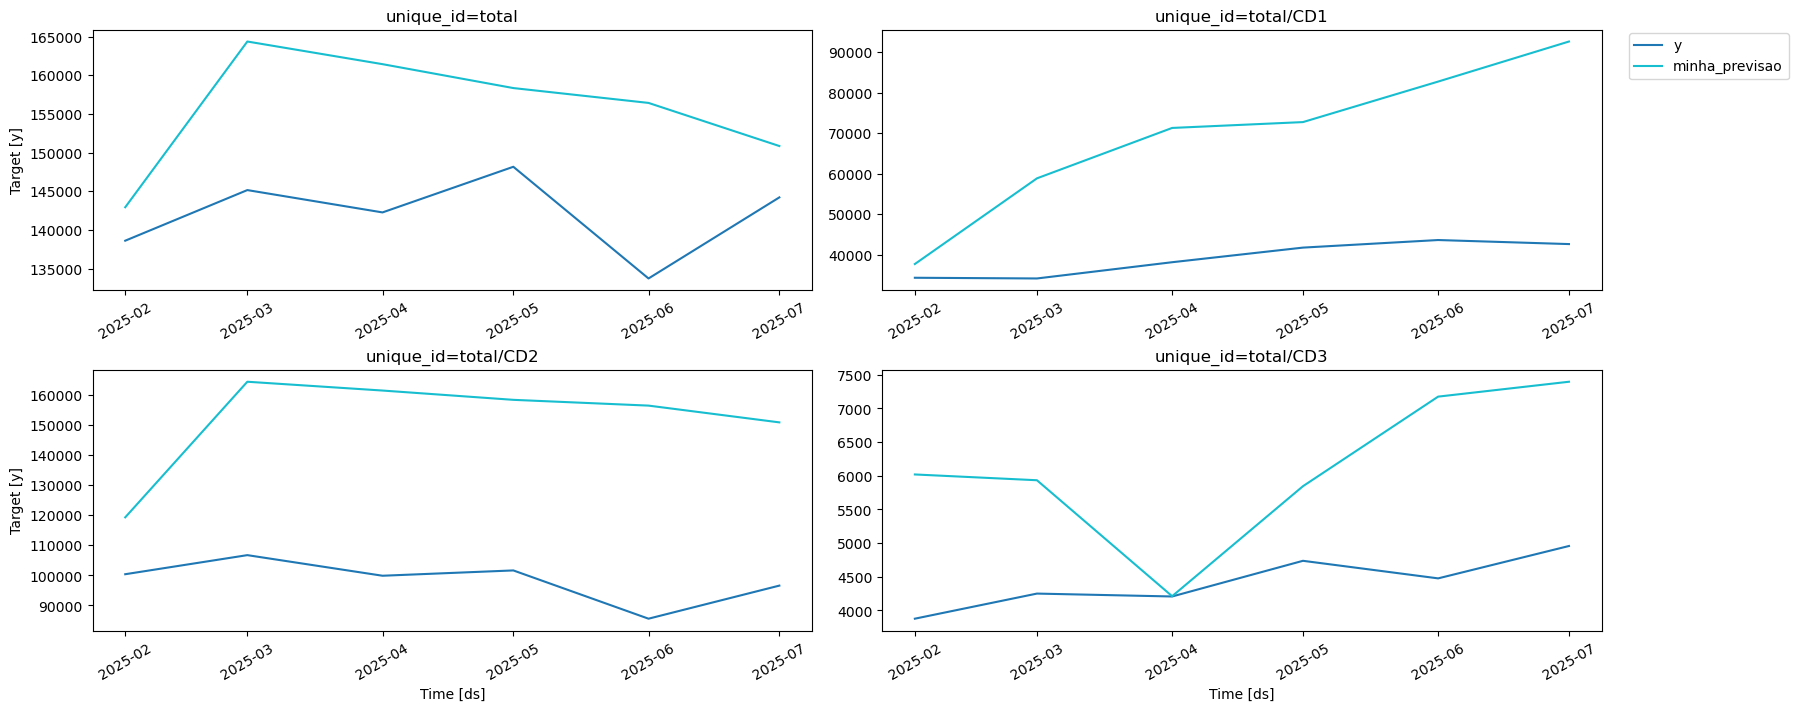

In [22]:
plot_series(df_pred,df_pred[['unique_id','ds','minha_previsao']])

In [26]:
pd.concat([train,base_forecasts])

,unique_id,ds,y,Base
0,total,2022-01-01,24816,NaN
1,total,2022-02-01,27690,NaN
2,total,2022-03-01,20979,NaN
3,total,2022-04-01,16943,NaN
4,total,2022-05-01,16950,NaN
...,...,...,...,...
19,total/CD3,2025-03-01,4250,5934.021973
20,total/CD3,2025-04-01,4207,4211.062988
21,total/CD3,2025-05-01,4737,5845.383789
22,total/CD3,2025-06-01,4476,7176.483887


In [33]:
S_df

,unique_id,total/CD1,total/CD2,total/CD3
0,total,1.0,1.0,1.0
1,total/CD1,1.0,0.0,0.0
2,total/CD2,0.0,1.0,0.0
3,total/CD3,0.0,0.0,1.0


In [ ]:
# Suas previsões brutas (sem reconciliação)
base_forecasts = df_pred.copy()  # tem unique_id, ds, minha_previsao (ou 'lgb')

# Renomeia a coluna de previsão pro padrão
base_forecasts = base_forecasts.rename(columns={'minha_previsao': 'Base'})

# Reconciliação (a mágica acontece aqui)
reconcilers = [
    MinTrace(method='ols'),                    # 1º lugar em 70% dos casos
    MinTrace(method='wls_var'),                # 2º lugar, rei do varejo
    MinTrace(method='wls_struct'),             # bom quando tem estrutura forte
    MinTrace(method='mint_shrink'),            # o mais moderno (venceu M5)
] 

rec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec = rec.reconcile(Y_hat_df=base_forecasts, Y_df=pd.concat([train,base_forecasts]),S_df=S_df, tags=tags)

In [31]:
Y_rec[Y_rec['unique_id']=='total']

,unique_id,ds,y,Base,Base/MinTrace_method-ols,Base/MinTrace_method-wls_var,Base/MinTrace_method-wls_struct,Base/MinTrace_method-mint_shrink
0,total,2025-02-01,138616,142938.218750,147966.305542,144002.357824,152994.392334,144536.256200
1,total,2025-03-01,145157,164358.250000,180559.699829,167787.108040,196761.149658,169507.429924
2,total,2025-04-01,142270,161431.250000,180308.566528,165426.425693,199185.883057,167430.879682
3,total,2025-05-01,148169,158342.109375,177988.353760,162500.020162,197634.598145,164586.121376
4,total,2025-06-01,133734,156422.906250,178899.152222,161179.755638,201375.398193,163566.355494
5,total,2025-07-01,144212,150850.796875,175851.293335,156141.876019,200851.789795,158796.508884


In [281]:
Y_rec[Y_rec['unique_id']!='total'].groupby('ds').sum()

,unique_id,y,Base,Base/MinTrace_method-ols,Base/MinTrace_method-wls_var,Base/MinTrace_method-wls_struct,Base/MinTrace_method-mint_shrink
ds,,,,,,,
2025-02-01,total/CD1total/CD2total/CD3,179486.0,175615.151005,165418.212035,162476.238874,168817.191692,161529.701474
2025-03-01,total/CD1total/CD2total/CD3,195886.0,242521.727375,201308.457499,189417.797542,215046.214124,185592.149335
2025-04-01,total/CD1total/CD2total/CD3,187806.0,255236.337330,208174.240772,194596.104684,223861.606291,190227.535388
2025-05-01,total/CD1total/CD2total/CD3,197854.0,275487.428646,210510.140614,191763.197234,232169.236625,185731.638801
2025-06-01,total/CD1total/CD2total/CD3,171053.0,272647.422770,206301.859524,187160.147775,228417.047272,181001.578317
2025-07-01,total/CD1total/CD2total/CD3,184420.0,275314.068544,203615.782206,182929.727815,227515.210986,176274.288403


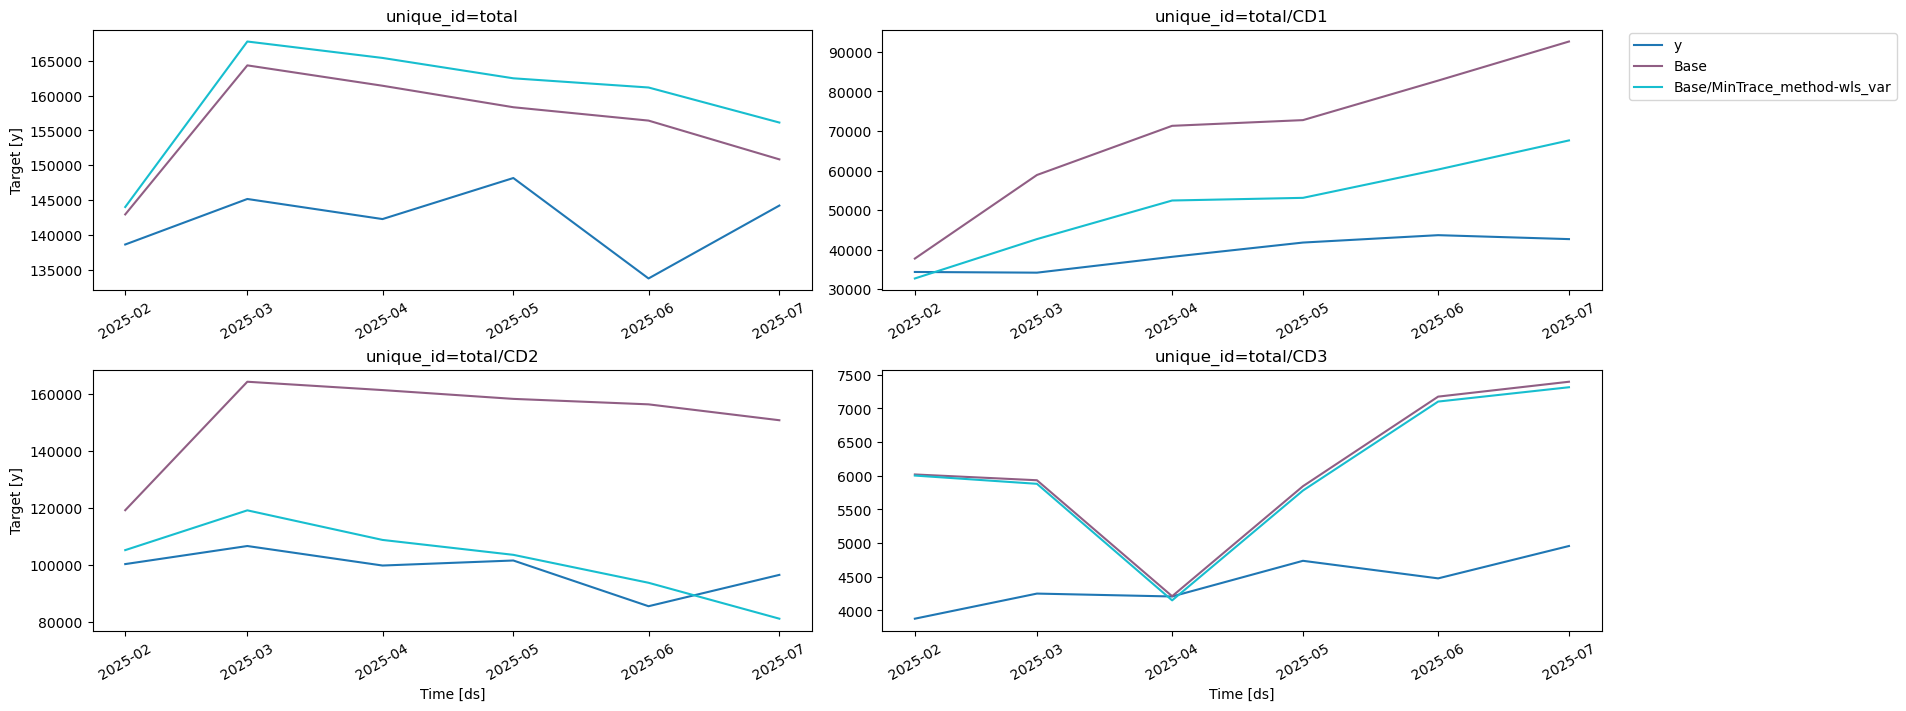

In [32]:
plot_series(Y_rec,Y_rec[['unique_id','ds','Base','Base/MinTrace_method-wls_var']])

In [285]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from utilsforecast.losses import rmsse  # ou from statsforecast.metrics import rmsse

def calculate_wrmsse_hierarchical(
    Y_train_df,
    Y_test_df,
    Y_hat_df,
    model_col,
    seasonality=12,
    id_col='unique_id',
    target_col='y'
):
    """
    Calcula WRMSSE para previsões hierárquicas com sazonalidade.
    
    Parâmetros:
    - Y_train_df: DataFrame com histórico de treino (unique_id, ds, y)
    - Y_test_df:  DataFrame com valores reais do teste (unique_id, ds, y)
    - Y_hat_df:   DataFrame com previsões reconciliadas (unique_id, ds, model_col)
    - model_col:  Nome da coluna com a previsão (ex: 'Prophet/TopDown_method=average_proportions')
    - seasonality: Período sazonal (12 para mensal, 4 para trimestral, etc.)
    - id_col, target_col: nomes das colunas
    
    Retorna:
    - wrmsse_final: WRMSSE ponderado
    - rmsse_by_level: dict com RMSSE por nível
    - weights: dict com pesos por nível
    """
    
    # 1. Merge: reais (teste) + previsão
    df_eval = Y_test_df[[id_col, 'ds', target_col]].merge(
        Y_hat_df[[id_col, 'ds', model_col]],
        on=[id_col, 'ds'],
        how='inner'
    ).dropna()
    
    if df_eval.empty:
        raise ValueError("Nenhum dado em comum entre Y_test_df e Y_hat_df!")
    
    df_eval = df_eval.rename(columns={model_col: 'y_hat', target_col: 'y'})
    
    # 2. Calcula RMSSE por unique_id
    rmsse_dict = {}
    weights_dict = {}
    
    for uid in df_eval[id_col].unique():
        subset = df_eval[df_eval[id_col] == uid]
        y = subset['y'].values
        y_hat = subset['y_hat'].values
        
        # Treino para escala
        train_series = Y_train_df[Y_train_df[id_col] == uid][target_col].values
        train_df = pd.DataFrame({target_col: train_series})
        
        # RMSSE com sazonalidade
        try:
            rmsse_val = rmsse(
                y=y,
                y_hat=y_hat,
                train_df=train_df,
                seasonality=seasonality
            )
        except:
            # Fallback se falhar (ex: treino muito curto)
            mse = np.mean((y - y_hat) ** 2)
            if len(train_series) >= seasonality + 1:
                diffs = train_series[seasonality:] - train_series[:-seasonality]
                scale = np.mean(diffs ** 2)
            else:
                diffs = np.diff(train_series) if len(train_series) > 1 else [1.0]
                scale = np.mean(np.square(diffs))
            scale = max(scale, 1e-8)
            rmsse_val = np.sqrt(mse / scale)
        
        rmsse_dict[uid] = rmsse_val
        weights_dict[uid] = y.sum()  # peso = volume real no teste
    
    # 3. Normaliza pesos
    total_weight = sum(weights_dict.values())
    if total_weight == 0:
        n = len(weights_dict)
        weights_normalized = {uid: 1/n for uid in weights_dict}
    else:
        weights_normalized = {uid: w / total_weight for uid, w in weights_dict.items()}
    
    # 4. WRMSSE final
    wrmsse_final = sum(rmsse_dict[uid] * weights_normalized[uid] for uid in rmsse_dict)
    
    return wrmsse_final, rmsse_dict, weights_normalized

In [287]:
wrmsse_score,rmsse_by_level,weights = calculate_wrmsse_hierarchical(
    train,
    valid,
    Y_rec,
    model_col='Base/MinTrace_method-wls_var',
    seasonality=12,
    id_col='unique_id',
    target_col='y'
)
# Resultado
print(f"WRMSSE Final: {wrmsse_score:.4f}\n")
print("RMSSE por nível:")
for uid in rmsse_by_level:
    print(f"  {uid:12}: {rmsse_by_level[uid]:.4f} (peso: {weights[uid]:.3f})")

WRMSSE Final: 0.2335

RMSSE por nível:
  total       : 0.1253 (peso: 0.500)
  total/CD1   : 0.6581 (peso: 0.137)
  total/CD2   : 0.2175 (peso: 0.349)
  total/CD3   : 0.3410 (peso: 0.015)


In [320]:
#global model cds-lojas
train,valid = train_valid_split(Y_df.drop(columns=['estoque_unidades_inicio_sum']))

C:\Users\eduar\AppData\Local\Temp\ipykernel_22816\35886996.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid = df.groupby('unique_id').tail(horizon)


In [321]:
train.describe()

,ds,y
count,12371,12371.000000
mean,2023-07-03 22:31:25.118422272,412.294722
min,2022-01-01 00:00:00,0.000000
25%,2022-10-01 00:00:00,65.000000
50%,2023-07-01 00:00:00,114.000000
75%,2024-04-01 00:00:00,184.000000
max,2025-01-01 00:00:00,122543.000000
std,NaN,3591.982103


In [322]:
def config_fn(trial):
    # FORÇA parâmetros que funcionam bem com poisson
    return {
        'model_params': {
            'objective': 'poisson',
            'learning_rate': trial.suggest_float('lr', 0.001, 0.2, log=True),     # nunca muito baixo
            'num_leaves': trial.suggest_int('num_leaves', 8, 64),                # range seguro
            'max_depth': trial.suggest_int('max_depth', 3, 10),                  # limita profundidade
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),    # evita overfitting/underfitting
            'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
            'bagging_freq': 1,
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True), # regularização leve
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 3000, log=True), # MUITAS árvores
            'verbosity': -1,
        },
        
        'mlf_init_params': {
            'lags': [1,2,3,4,5,6,12],
            'lag_transforms': {
                1: [ExpandingMean()],
                2: [RollingMean(3), RollingMean(6)],
                12: [RollingMean(3)]
            },
            # opcional: descomente se quiser testar
            'target_transforms': [LocalBoxCox()],
             'date_features': ['month', 'quarter'],
        },
        'mlf_fit_params': {'static_features': ['unique_id']},
    }
    
def loss(df, train_df):
    return smape(df, models=['model'])['model'].mean()


optuna.logging.set_verbosity(optuna.logging.WARNING)
objective = mlforecast_objective(
    df=train,
    config_fn=config_fn,
    loss=loss,    
    model=lgbm.LGBMRegressor(),
    freq='MS',
    n_windows=5,
    step_size=1,
    id_col='unique_id',
    h=6,
)
study = optuna.create_study(
    direction='minimize', sampler=optuna.samplers.TPESampler(seed=3)
)
study.optimize(objective, n_trials=40)
best_cfg = study.best_trial.user_attrs['config']

final_model = MLForecast(
    models={'minha_previsao':lgbm.LGBMRegressor(**best_cfg['model_params'])},
    freq='MS',
    **best_cfg['mlf_init_params'],
)

final_model.fit(train, **best_cfg['mlf_fit_params'])

preds = final_model.predict(6)

df_pred = valid.merge(preds,on=['unique_id','ds'])

c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\mlforecast\core.py:434: UserWarning: The following series were dropped completely due to the transformations and features: ['total/CD2/23...-00a9c22ad5eb', 'total/CD2/70...-4f2a56a93e86', 'total/CD2/81...-9bbb90812d14', 'total/CD2/cb...-e566d76e8ee0'].
These series won't show up if you use `MLForecast.forecast_fitted_values()`.
You can set `dropna=False` or use transformations that require less samples to mitigate this
  warnings.warn(
[W 2025-11-25 12:37:11,591] Trial 0 failed with parameters: {'lr': 0.018509832782964617, 'num_leaves': 48, 'max_depth': 5, 'min_data_in_leaf': 13, 'feature_fraction': 0.9678840863042963, 'bagging_fraction': 0.9688879266800314, 'lambda_l1': 1.0108401504390248e-07, 'lambda_l2': 4.5492837438963356e-07, 'n_estimators': 337} because of the following error: LightGBMError('[poisson]: at least one target label is negative').
Traceback (most recent call last):
  File "c:\Users\eduar\AppData\Loca

LightGBMError: [poisson]: at least one target label is negative

In [211]:
plot_series(df_pred,a)

TypeError: plot_series() got an unexpected keyword argument 'n_series'

In [184]:
best_cfg

{'model_params': {'objective': 'poisson',
  'learning_rate': 0.12230901668716515,
  'num_leaves': 56,
  'max_depth': 7,
  'min_data_in_leaf': 6,
  'feature_fraction': 0.8002128606944451,
  'bagging_fraction': 0.8026622891774776,
  'bagging_freq': 1,
  'lambda_l1': 4.078007014915368e-06,
  'lambda_l2': 4.972775870239231e-08,
  'n_estimators': 674,
  'verbosity': -1},
 'mlf_init_params': {'lags': [1, 2, 3, 4, 5, 6, 12],
  'lag_transforms': {1: [ExpandingMean()],
   2: [RollingMean(window_size=3), RollingMean(window_size=6)],
   12: [RollingMean(window_size=3)]}},
 'mlf_fit_params': {'static_features': []}}

In [178]:
best_cfg

{'model_params': {'objective': 'poisson',
  'learning_rate': 0.12230901668716515,
  'num_leaves': 56,
  'max_depth': 7,
  'min_data_in_leaf': 6,
  'feature_fraction': 0.8002128606944451,
  'bagging_fraction': 0.8026622891774776,
  'bagging_freq': 1,
  'lambda_l1': 4.078007014915368e-06,
  'lambda_l2': 4.972775870239231e-08,
  'n_estimators': 674,
  'verbosity': -1},
 'mlf_init_params': {'lags': [1, 2, 3, 4, 5, 6, 12],
  'lag_transforms': {1: [ExpandingMean()],
   2: [RollingMean(window_size=3), RollingMean(window_size=6)],
   12: [RollingMean(window_size=3)]}},
 'mlf_fit_params': {'static_features': []}}

In [188]:
preds = final_model.predict(6)

<Axes: xlabel='ds'>

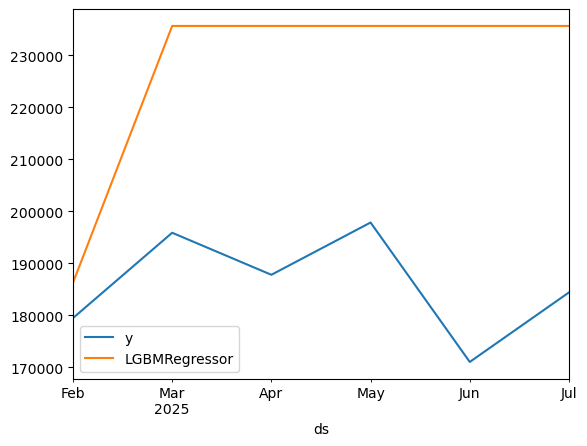

In [189]:
valid.merge(preds,on=['unique_id','ds']).set_index('ds').plot()

In [122]:
best_cfg

{'model_params': {'objective': 'poisson',
  'learning_rate': 0.013745714657342874,
  'num_leaves': 22,
  'max_depth': 4,
  'min_data_in_leaf': 5,
  'feature_fraction': 0.8855164038061759,
  'bagging_fraction': 0.7790240858305753,
  'bagging_freq': 1,
  'lambda_l1': 0.006910402916870853,
  'lambda_l2': 0.00022321008636918155,
  'n_estimators': 349,
  'verbosity': -1},
 'mlf_init_params': {'lags': [1, 2, 3, 4, 5, 6, 12],
  'lag_transforms': {1: [ExpandingMean()],
   2: [RollingMean(window_size=3), RollingMean(window_size=6)],
   12: [RollingMean(window_size=3)]}},
 'mlf_fit_params': {}}

In [123]:
preds

,unique_id,ds,LGBMRegressor
0,total,2025-02-01,62983.152125
1,total,2025-03-01,78631.792248
2,total,2025-04-01,74646.360800
3,total,2025-05-01,76452.923747
4,total,2025-06-01,76540.560084
5,total,2025-07-01,74900.852101


In [33]:
final_model.preprocess(train)

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,expanding_mean_lag6,rolling_mean_lag6_window_size6
12,total,2023-01-01,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,19704.0,20519.0,26458.0,31508.0,25907.0,23510.000000,23110.500000
13,total,2023-02-01,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,19704.0,20519.0,26458.0,31508.0,22669.500000,20656.833333
14,total,2023-03-01,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,19704.0,20519.0,26458.0,22569.111111,19874.833333
15,total,2023-04-01,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,19704.0,20519.0,23250.200000,21351.666667
16,total,2023-05-01,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,19704.0,23638.000000,22653.666667
17,total,2023-06-01,31149.0,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,26043.666667,27930.166667
18,total,2023-07-01,41452.0,31149.0,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,25959.692308,28817.666667
19,total,2023-08-01,57184.0,41452.0,31149.0,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,25762.285714,29886.000000
20,total,2023-09-01,61356.0,57184.0,41452.0,31149.0,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,25873.600000,30830.333333
21,total,2023-10-01,59847.0,61356.0,57184.0,41452.0,31149.0,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,26030.812500,30665.166667


In [184]:
# ISSO MATA O ERRO PRA SEMPRE
train['unique_id'] = train['unique_id'].astype('category')

In [186]:
train.dtypes

unique_id          category
ds           datetime64[ns]
y                   float64
dtype: object

In [55]:
horizon = 6
valid = df_.groupby('unique_id').tail(horizon)
train = df_.drop(valid.index)
train.shape, valid.shape

((24, 3), (6, 3))

In [171]:
from mlforecast.auto import AutoModel

ImportError: cannot import name 'AutoML' from 'mlforecast' (c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\mlforecast\__init__.py)

In [217]:
params = {
    "objective": "poisson",           # ótimo para vendas/contagens
    "metric": "rmse",
    "learning_rate": 0.03,            # bom valor conservador
    "num_iterations": 500,            # 300–600 é o máximo seguro com poucos dados
    "num_leaves": 16,                 # MÁXIMO 16–24 com <150 linhas! (128 = overfit garantido)
    "max_depth": 5,                   # limita profundidade (evita árvores gigantes)
    "min_data_in_leaf": 6,            # era 100 → impossível com poucos dados! 5–10 é realista
    "min_sum_hessian_in_leaf": 1,     # padrão ok
    "feature_fraction": 0.8,          # colsample_bytree
    "bagging_fraction": 0.8,          # subsample
    "bagging_freq": 1,
    "lambda_l2": 1.0,                 # aumentei um pouco → mais regularização
    "lambda_l1": 0.5,                 # L1 também ajuda com features ruins
    "verbosity": -1,
    "seed": 42,
    "force_row_wise": True,
}

In [74]:
from mlforecast.feature_engineering import transform_exog

In [75]:
transform_exog?

Signature:
transform_exog(
    df: pandas.core.frame.DataFrame,
    lags: Optional[Iterable[int]] = None,
    lag_transforms: Optional[Dict[int, List[Union[Callable, Tuple[Callable, Any]]]]] = None,
    id_col: str = 'unique_id',
    time_col: str = 'ds',
    num_threads: int = 1,
) -> pandas.core.frame.DataFrame
Docstring:
Compute lag features for dynamic exogenous regressors.

Parameters
----------
df : pandas or polars DataFrame
    Dataframe with ids, times and values for the exogenous regressors.
lags : list of int, optional (default=None)
    Lags of the target to use as features.
lag_transforms : dict of int to list of functions, optional (default=None)
    Mapping of target lags to their transformations.
id_col : str (default='unique_id')
    Column that identifies each serie.
time_col : str (default='ds')
    Column that identifies each timestep, its values can be timestamps or integers.
num_threads : int (default=1)
    Number of threads to use when computing the features.

R

In [ ]:
mlforecast_objective(
        df=train,
        config_fn=config_fn,
        loss=loss,    
        model = self.model,
        freq='MS',
        n_windows=self.mlf_n_window,
        step_size=self.mlf_step_size,
        id_col=self.mlf_id_col,
        h=self.mlf_h,)

In [ ]:
import stat

fcst = MLForecast(
    models = lgbm.LGBMRegressor(objective='poisson',
            learning_rate=0.03,
            num_leaves=16,
            max_depth=5,
            min_data_in_leaf=6,
            feature_fraction=0.8,
            bagging_fraction=0.8,
            lambda_l1=0.5,
            lambda_l2=1.0,
            verbosity=-1,
            n_jobs=4),
    freq='MS',
    lags=range(1,13,1),
    lag_transforms={
        1:[ExpandingMean()],
        2:[RollingMean(window_size=3)],
    },
    
    #date_features = ['month','year'],
    num_threads = 1
)

In [125]:
fcst.fit(train,static_features=[])

MLForecast(models=[LGBMRegressor], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'expanding_mean_lag1', 'rolling_mean_lag2_window_size3'], date_features=[], num_threads=1)

In [127]:
fcst.preprocess(train,static_features=[])

,unique_id,ds,y,estoque_unidades_inicio_sum,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,expanding_mean_lag1,rolling_mean_lag2_window_size3
12,total,2023-01-01,24952.0,45098.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,19704.0,20519.0,26458.0,31508.0,25907.0,26043.666667,26220.666667
13,total,2023-02-01,23196.0,37632.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,19704.0,20519.0,26458.0,31508.0,25959.692308,36467.333333
14,total,2023-03-01,27432.0,34948.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,19704.0,20519.0,26458.0,25762.285714,34991.333333
15,total,2023-04-01,28389.0,43628.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,19704.0,20519.0,25873.600000,33551.333333
16,total,2023-05-01,25992.0,38905.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,19704.0,26030.812500,25193.333333
17,total,2023-06-01,31149.0,38081.0,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,20847.0,26028.529412,26339.000000
18,total,2023-07-01,41452.0,37206.0,31149.0,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,19627.0,26313.000000,27271.000000
19,total,2023-08-01,57184.0,47976.0,41452.0,31149.0,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,16786.0,27109.789474,28510.000000
20,total,2023-09-01,61550.0,43156.0,57184.0,41452.0,31149.0,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,21766.0,28613.500000,32864.333333
21,total,2023-10-01,60994.0,36909.0,61550.0,57184.0,41452.0,31149.0,25992.0,28389.0,27432.0,23196.0,24952.0,52506.0,27516.0,29380.0,30181.904762,43261.666667


In [132]:
fcst.fit(train,static_features=[],as_numpy=True,fitted=True)

c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MLForecast(models=[LGBMRegressor], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'expanding_mean_lag1', 'rolling_mean_lag2_window_size3'], date_features=[], num_threads=1)

In [139]:
predict = fcst.predict(6,X_df=train[['unique_id','ds','estoque_unidades_inicio_sum']])
predict

ValueError: Found missing inputs in X_df. It should have one row per id and time for the complete forecasting horizon.
You can get the expected structure by running `MLForecast.make_future_dataframe(h)` or get the missing combinatins in your current `X_df` by running `MLForecast.get_missing_future(h, X_df)`.

In [144]:
# Seu Y_df tem: unique_id, ds, y (vendas), estoque_unidades_inicio_sum

# Crie df para modelo de estoque (target = estoque, exog = lags de y)
estoque_df = Y_df[['unique_id', 'ds', 'estoque_unidades_inicio_sum', 'y']].copy()
estoque_df.rename(columns={'estoque_unidades_inicio_sum': 'y_estoque'}, inplace=True)  # Renomeia para target

# Opcional: adicione lags de vendas como exog para estoque
estoque_transformed = transform_exog(
    df=estoque_df,
    lags=[1, 2, 3, 6, 12],  # lags de vendas para prever estoque
    lag_transforms={
        1: [ExpandingMean(), RollingMean(3)],
        12: [RollingMean(3)]
    },
    id_col='unique_id',
    time_col='ds'
)

# Modelo para estoque (Poisson se contagem, ou regressão normal)
estoque_fcst = MLForecast(
    models=lgbm.LGBMRegressor(objective='poisson', n_estimators=1000, verbosity=-1),  # ou 'regression' se não for contagem
    freq='MS',
    lags=[1, 2, 3, 6, 12],  # lags do estoque histórico
    lag_transforms={
        1: [ExpandingMean()],
        2: [RollingMean(3)],
        12: [RollingMean(3)]
    }
)
estoque_fcst.fit(estoque_transformed, static_features=[])

c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\mlforecast\core.py:434: UserWarning: The following series were dropped completely due to the transformations and features: ['total/CD1/3e...-40a183b7da73', 'total/CD2/9f...-82379068322a', 'total/CD2/ae...-78834cdba01a', 'total/CD2/d5...-9476259c61eb', 'total/CD2/d9...-bc37a1f61c23'].
These series won't show up if you use `MLForecast.forecast_fitted_values()`.
You can set `dropna=False` or use transformations that require less samples to mitigate this
  warnings.warn(


MLForecast(models=[LGBMRegressor], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag6', 'lag12', 'expanding_mean_lag1', 'rolling_mean_lag2_window_size3', 'rolling_mean_lag12_window_size3'], date_features=[], num_threads=1)

In [ ]:
# Modelo de vendas (sem transform_exog no estoque)
vendas_fcst = MLForecast(
    models=lgb.LGBMRegressor(objective='poisson', n_estimators=2000, verbosity=-1),
    freq='MS',
    lags=[1, 2, 3, 4, 5, 6, 12],  # só lags do target (vendas)
    lag_transforms={
        1: [ExpandingMean()],
        2: [RollingMean(3), RollingMean(6)],
        12: [RollingMean(3)]
    },
    target_transforms=[LocalBoxCox()]
)
vendas_fcst.fit(Y_df, static_features=[])  # Estoque como dinâmico (lag0 automático)

In [143]:
from mlforecast.feature_engineering import transform_exog
from mlforecast.lag_transforms import ExpandingMean, RollingMean

# 1. Transforme o estoque para usar APENAS lags históricos (≥1)
train_with_exog_lags = transform_exog(
    df=Y_df.copy(),
    lags=[1, 2, 3, 6, 12],                    # ← NENHUM lag0!
    lag_transforms={
        1: [ExpandingMean(), RollingMean(3), RollingMean(6)],
        2: [RollingMean(3)],
        3: [RollingMean(3)],
        6: [RollingMean(3)],
        12: [RollingMean(3)]
    },
    id_col='unique_id',
    time_col='ds',
    num_threads=6
)

# 2. Treine normalmente
fcst = MLForecast(
    models=lgbm.LGBMRegressor(objective='poisson',
            learning_rate=0.03,
            num_leaves=16,
            max_depth=5,
            min_data_in_leaf=6,
            feature_fraction=0.8,
            bagging_fraction=0.8,
            lambda_l1=0.5,
            lambda_l2=1.0,
            verbosity=-1,
            n_jobs=4),
    freq='MS',
    lags=range(1,13,1),
    lag_transforms={
        1:[ExpandingMean()],
        2:[RollingMean(window_size=3)],
    },
    
    #date_features = ['month','year'],
    num_threads = 1)

fcst.fit(train_with_exog_lags, static_features=[])   # tudo dinâmico

# 3. Preveja → SEM X_df! Funciona direto!
pred = fcst.predict(h=6,X_df=   # ← SIMPLES ASSIM!

c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\mlforecast\core.py:434: UserWarning: The following series were dropped completely due to the transformations and features: ['total/CD1/3e...-40a183b7da73', 'total/CD2/9f...-82379068322a', 'total/CD2/ae...-78834cdba01a', 'total/CD2/d5...-9476259c61eb', 'total/CD2/d9...-bc37a1f61c23'].
These series won't show up if you use `MLForecast.forecast_fitted_values()`.
You can set `dropna=False` or use transformations that require less samples to mitigate this
  warnings.warn(
c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag2, lag3, lag4, lag5, lag6, lag7, lag8, lag9, lag10, lag11, lag12, expanding_mean_lag1, rolling_mean_lag2_window_size3.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


KeyError: "['estoque_unidades_inicio_sum', 'y_lag1', 'y_lag2', 'y_lag3', 'y_lag6', 'y_lag12', 'y_expanding_mean_lag1', 'y_rolling_mean_lag1_window_size3', 'y_rolling_mean_lag1_window_size6', 'y_rolling_mean_lag2_window_size3', 'y_rolling_mean_lag3_window_size3', 'y_rolling_mean_lag6_window_size3', 'y_rolling_mean_lag12_window_size3', 'estoque_unidades_inicio_sum_lag1', 'estoque_unidades_inicio_sum_lag2', 'estoque_unidades_inicio_sum_lag3', 'estoque_unidades_inicio_sum_lag6', 'estoque_unidades_inicio_sum_lag12', 'estoque_unidades_inicio_sum_expanding_mean_lag1', 'estoque_unidades_inicio_sum_rolling_mean_lag1_window_size3', 'estoque_unidades_inicio_sum_rolling_mean_lag1_window_size6', 'estoque_unidades_inicio_sum_rolling_mean_lag2_window_size3', 'estoque_unidades_inicio_sum_rolling_mean_lag3_window_size3', 'estoque_unidades_inicio_sum_rolling_mean_lag6_window_size3', 'estoque_unidades_inicio_sum_rolling_mean_lag12_window_size3'] not in index"

<Axes: xlabel='ds'>

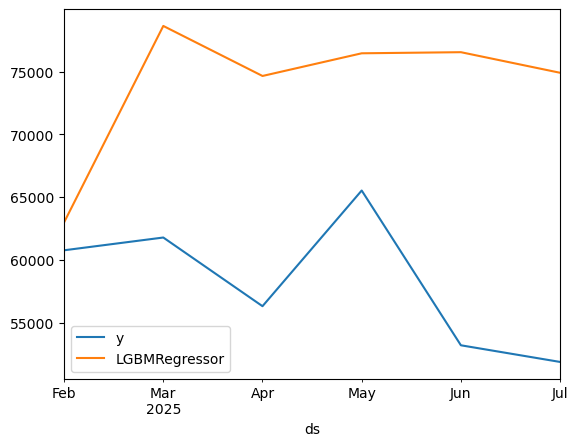

In [124]:
valid.merge(preds,on=['unique_id','ds']).set_index('ds').plot()

In [261]:
train

,unique_id,ds,y
0,total,2023-02-01,20292.0
1,total,2023-03-01,20389.0
2,total,2023-04-01,19887.0
3,total,2023-05-01,17204.0
4,total,2023-06-01,19006.0
5,total,2023-07-01,24550.0
6,total,2023-08-01,29959.0
7,total,2023-09-01,32075.0
8,total,2023-10-01,30297.0
9,total,2023-11-01,38604.0


In [85]:
fcst.cross_validation??

Signature:
fcst.cross_validation(
    df: pandas.core.frame.DataFrame,
    n_windows: int,
    h: int,
    id_col: str = 'unique_id',
    time_col: str = 'ds',
    target_col: str = 'y',
    step_size: Optional[int] = None,
    static_features: Optional[List[str]] = None,
    dropna: bool = True,
    keep_last_n: Optional[int] = None,
    refit: Union[bool, int] = True,
    max_horizon: Optional[int] = None,
    before_predict_callback: Optional[Callable] = None,
    after_predict_callback: Optional[Callable] = None,
    prediction_intervals: Optional[mlforecast.utils.PredictionIntervals] = None,
    level: Optional[List[Union[int, float]]] = None,
    input_size: Optional[int] = None,
    fitted: bool = False,
    as_numpy: bool = False,
    weight_col: Optional[str] = None,
) -> pandas.core.frame.DataFrame
Source:   
    def cross_validation(
        self,
        df: DFType,
        n_windows: int,
        h: int,
        id_col: str = "unique_id",
        time_col: str = "ds",
    

In [227]:
fcst.cross_validation?

Signature:
fcst.cross_validation(
    df: pandas.core.frame.DataFrame,
    n_windows: int,
    h: int,
    id_col: str = 'unique_id',
    time_col: str = 'ds',
    target_col: str = 'y',
    step_size: Optional[int] = None,
    static_features: Optional[List[str]] = None,
    dropna: bool = True,
    keep_last_n: Optional[int] = None,
    refit: Union[bool, int] = True,
    max_horizon: Optional[int] = None,
    before_predict_callback: Optional[Callable] = None,
    after_predict_callback: Optional[Callable] = None,
    prediction_intervals: Optional[mlforecast.utils.PredictionIntervals] = None,
    level: Optional[List[Union[int, float]]] = None,
    input_size: Optional[int] = None,
    fitted: bool = False,
    as_numpy: bool = False,
    weight_col: Optional[str] = None,
) -> pandas.core.frame.DataFrame
Docstring:
Perform time series cross validation.
Creates `n_windows` splits where each window has `h` test periods,
trains the models, computes the predictions and merges the actua

In [286]:
cv_results = fcst.cross_validation(
    df=train,           # seu dataframe com 24+ meses
    n_windows=5,     # ← MÁXIMO que dá pra fazer com 24 meses
    h=6,             # ← seu horizonte real (6 meses)
    step_size=3,     # pula 3 em 3 meses (equilíbrio perfeito)
    refit=True,      # retraina a cada janela (mais realista)
    fitted=True      # salva previsões in-sample pra analisar
)

In [287]:
cv_results

,unique_id,ds,cutoff,y,LGBMRegressor
0,total,2023-08-01,2023-07-01,29959.0,21778.000000
1,total,2023-09-01,2023-07-01,32075.0,21778.000000
2,total,2023-10-01,2023-07-01,30297.0,21778.000000
3,total,2023-11-01,2023-07-01,38604.0,21778.000000
4,total,2023-12-01,2023-07-01,52187.0,21778.000000
5,total,2024-01-01,2023-07-01,19663.0,21778.000000
6,total,2023-11-01,2023-10-01,38604.0,27177.400000
7,total,2023-12-01,2023-10-01,52187.0,27177.400000
8,total,2024-01-01,2023-10-01,19663.0,27177.400000
9,total,2024-02-01,2023-10-01,14388.0,27177.400000


In [248]:
print(len(train),len(valid))

24 6


In [275]:
fcst.preprocess(train)

,unique_id,ds,y,lag1,lag3,expanding_mean_lag1,rolling_mean_lag2_window_size3,month,year
4,total,2023-06-01,19006.0,17204.0,20389.0,19443.000000,20189.333333,6,2023
5,total,2023-07-01,24550.0,19006.0,19887.0,19355.600000,19160.000000,7,2023
6,total,2023-08-01,29959.0,24550.0,17204.0,20221.333333,18699.000000,8,2023
7,total,2023-09-01,32075.0,29959.0,19006.0,21612.428571,20253.333333,9,2023
8,total,2023-10-01,30297.0,32075.0,24550.0,22920.250000,24505.000000,10,2023
9,total,2023-11-01,38604.0,30297.0,29959.0,23739.888889,28861.333333,11,2023
10,total,2023-12-01,52187.0,38604.0,32075.0,25226.300000,30777.000000,12,2023
11,total,2024-01-01,19663.0,52187.0,30297.0,27677.272727,33658.666667,1,2024
12,total,2024-02-01,14388.0,19663.0,38604.0,27009.416667,40362.666667,2,2024
13,total,2024-03-01,19034.0,14388.0,52187.0,26038.538462,36818.000000,3,2024


In [252]:
train

,unique_id,ds,y
0,total,2023-02-01,20292.0
1,total,2023-03-01,20389.0
2,total,2023-04-01,19887.0
3,total,2023-05-01,17204.0
4,total,2023-06-01,19006.0
5,total,2023-07-01,24550.0
6,total,2023-08-01,29959.0
7,total,2023-09-01,32075.0
8,total,2023-10-01,30297.0
9,total,2023-11-01,38604.0


In [250]:
cv_results

,unique_id,ds,cutoff,y,LGBMRegressor
0,total,2024-05-01,2024-04-01,24893.0,19297.666667
1,total,2024-06-01,2024-04-01,26681.0,19297.666667
2,total,2024-07-01,2024-04-01,21151.0,19297.666667
3,total,2024-08-01,2024-04-01,22876.0,19297.666667
4,total,2024-09-01,2024-04-01,25538.0,19297.666667
5,total,2024-10-01,2024-04-01,20621.0,19297.666667
6,total,2024-06-01,2024-05-01,26681.0,20696.500000
7,total,2024-07-01,2024-05-01,21151.0,20696.500000
8,total,2024-08-01,2024-05-01,22876.0,20696.500000
9,total,2024-09-01,2024-05-01,25538.0,20696.500000


In [225]:
cv

,unique_id,ds,cutoff,y,LGBMRegressor
0,total,2024-08-01,2024-07-01,22876.0,21769.666667
1,total,2024-09-01,2024-07-01,25538.0,21769.666667
2,total,2024-10-01,2024-07-01,20621.0,21769.666667
3,total,2024-11-01,2024-07-01,27623.0,21769.666667
4,total,2024-12-01,2024-07-01,51994.0,21769.666667
5,total,2025-01-01,2024-07-01,28980.0,21769.666667


In [106]:
fcst.fit(train)

MLForecast(models=[LGBMRegressor], freq=MS, lag_features=['lag6', 'lag12', 'expanding_mean_lag1', 'rolling_mean_lag2_window_size3'], date_features=['month', 'year'], num_threads=1)

In [ ]:
fcst.fit(
    train,
    prediction_intervals=PredictionIntervals(n_windows=3, h=6)
);

TypeError: PredictionIntervals.__init__() got an unexpected keyword argument 'step_size'

In [134]:
predictions_w_intervals = fcst.predict(3, level=[50, 80, 95])
predictions_w_intervals.head()

,unique_id,ds,LGBMRegressor,LGBMRegressor-lo-95,LGBMRegressor-lo-80,LGBMRegressor-lo-50,LGBMRegressor-hi-50,LGBMRegressor-hi-80,LGBMRegressor-hi-95
0,total,2025-02-01,22546.111649,14562.028316,15585.778316,17455.028316,27637.194983,29506.444983,30530.194983
1,total,2025-03-01,22546.111649,-6986.096684,2506.278316,15448.528316,29643.694983,42585.944983,52078.319983
2,total,2025-04-01,22546.111649,13842.403316,16778.278316,20825.278316,24266.944983,28313.944983,31249.819983


In [129]:
fcst.predict(1)

,unique_id,ds,LGBMRegressor
0,total,2025-02-01,22546.111649


In [147]:
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss
from utilsforecast.evaluation import evaluate

In [148]:
cv

,unique_id,ds,cutoff,y,LGBMRegressor
0,total,2024-08-01,2024-07-01,22876.0,21769.666667
1,total,2024-09-01,2024-07-01,25538.0,21769.666667
2,total,2024-10-01,2024-07-01,20621.0,21769.666667
3,total,2024-11-01,2024-10-01,27623.0,22183.666667
4,total,2024-12-01,2024-10-01,51994.0,22183.666667
5,total,2025-01-01,2024-10-01,28980.0,22183.666667


In [151]:
evaluate(cv.drop(columns='cutoff'),metrics=[rmse],agg_fn='mean')

,metric,LGBMRegressor
0,rmse,12787.860207


In [ ]:
fcst.model

AttributeError: 'builtin_function_or_method' object has no attribute 'feature_importance'

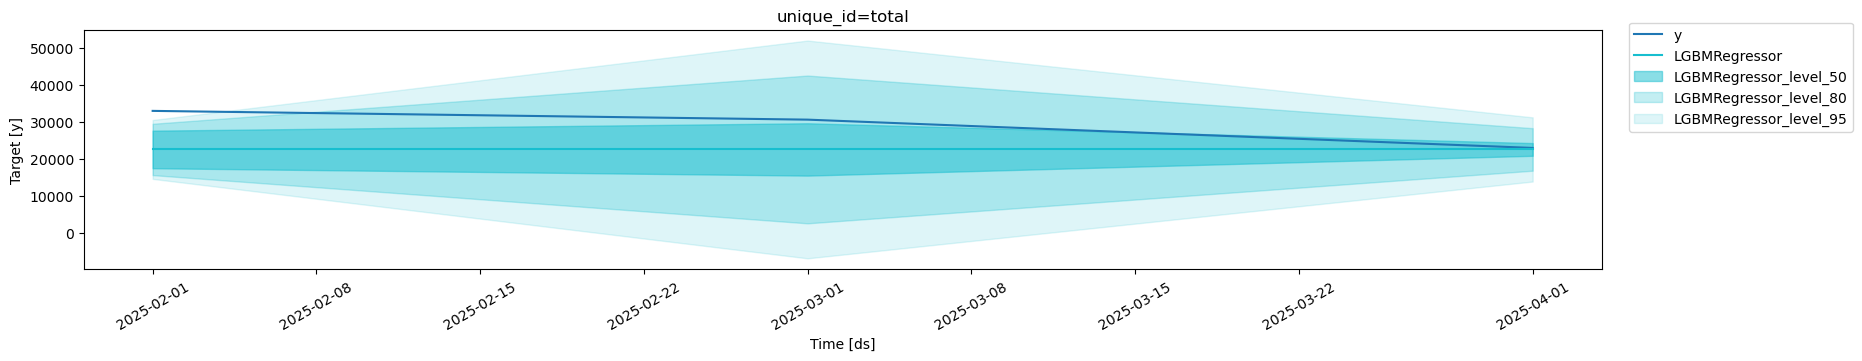

In [136]:
results = valid.merge(predictions_w_intervals, on=['unique_id', 'ds'])
fig = plot_series(forecasts_df=results, level=[50, 80, 95])
fig

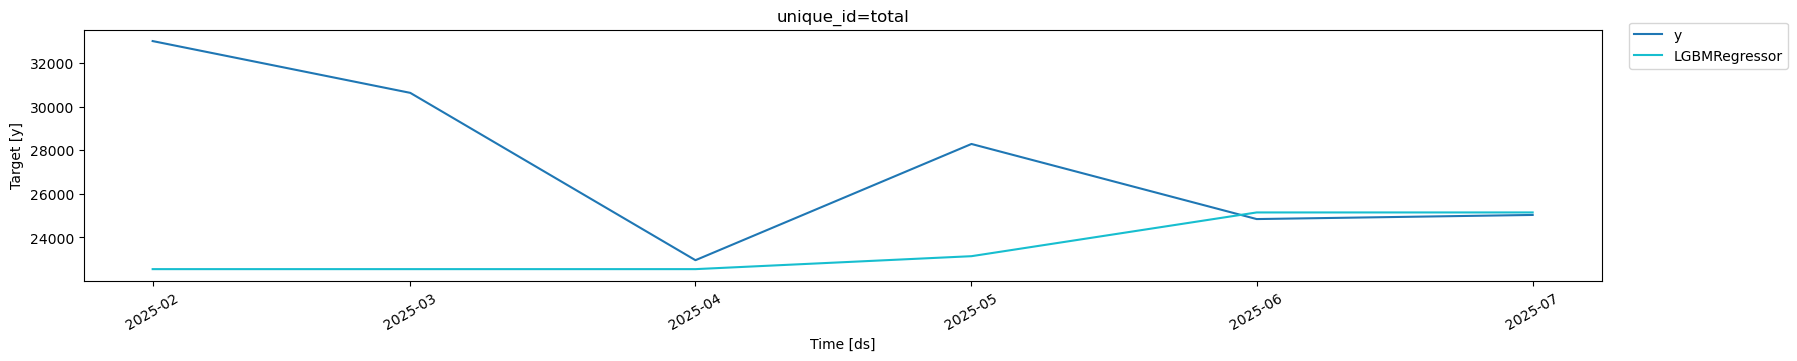

In [119]:
results = valid.merge(predictions, on=['unique_id', 'ds'])
fig = plot_series(forecasts_df=results)
fig

In [108]:
fcst.forecast_fitted_values()

,unique_id,ds,y,LGBMRegressor
0,total,2024-02-01,14388.0,23139.772484
1,total,2024-03-01,19034.0,23139.772484
2,total,2024-04-01,24471.0,23139.772484
3,total,2024-05-01,24893.0,25145.953415
4,total,2024-06-01,26681.0,29023.234161
5,total,2024-07-01,21151.0,24500.823144
6,total,2024-08-01,22876.0,26022.520086
7,total,2024-09-01,25538.0,26022.520086
8,total,2024-10-01,20621.0,28278.630582
9,total,2024-11-01,27623.0,28278.630582


In [44]:
fcst.preprocess(df_)

,unique_id,ds,y,lag6,lag12,expanding_mean_lag1,rolling_mean_lag2_window_size3,month,year
12,total,2024-02-01,14388.0,29959.0,20292.0,27009.416667,40362.666667,2,2024
13,total,2024-03-01,19034.0,32075.0,20389.0,26038.538462,36818.000000,3,2024
14,total,2024-04-01,24471.0,30297.0,19887.0,25538.214286,28746.000000,4,2024
15,total,2024-05-01,24893.0,38604.0,17204.0,25467.066667,17695.000000,5,2024
16,total,2024-06-01,26681.0,52187.0,19006.0,25431.187500,19297.666667,6,2024
17,total,2024-07-01,21151.0,19663.0,24550.0,25504.705882,22799.333333,7,2024
18,total,2024-08-01,22876.0,14388.0,29959.0,25262.833333,25348.333333,8,2024
19,total,2024-09-01,25538.0,19034.0,32075.0,25137.210526,24241.666667,9,2024
20,total,2024-10-01,20621.0,24471.0,30297.0,25157.250000,23569.333333,10,2024
21,total,2024-11-01,27623.0,24893.0,38604.0,24941.238095,23188.333333,11,2024


In [53]:
fcst.fit?

Signature:
fcst.fit(
    df: Union[pandas.core.frame.DataFrame, utilsforecast.compat.pl_DataFrame],
    id_col: str = 'unique_id',
    time_col: str = 'ds',
    target_col: str = 'y',
    static_features: Optional[List[str]] = None,
    dropna: bool = True,
    keep_last_n: Optional[int] = None,
    max_horizon: Optional[int] = None,
    prediction_intervals: Optional[mlforecast.utils.PredictionIntervals] = None,
    fitted: bool = False,
    as_numpy: bool = False,
    weight_col: Optional[str] = None,
) -> 'MLForecast'
Docstring:
Apply the feature engineering and train the models.

Parameters
----------
df : pandas or polars DataFrame
    Series data in long format.
id_col : str (default='unique_id')
    Column that identifies each serie.
time_col : str (default='ds')
    Column that identifies each timestep, its values can be timestamps or integers.
target_col : str (default='y')
    Column that contains the target.
static_features : list of str, optional (default=None)
    Names of

In [109]:
predictions = fcst.predict(6)

In [110]:
predictions

,unique_id,ds,LGBMRegressor
0,total,2025-02-01,22546.111649
1,total,2025-03-01,22546.111649
2,total,2025-04-01,22546.111649
3,total,2025-05-01,23139.772484
4,total,2025-06-01,25145.953415
5,total,2025-07-01,25145.953415


In [111]:
valid

,unique_id,ds,y
24,total,2025-02-01,33005.0
25,total,2025-03-01,30630.0
26,total,2025-04-01,22956.0
27,total,2025-05-01,28286.0
28,total,2025-06-01,24842.0
29,total,2025-07-01,25031.0


<Axes: xlabel='ds'>

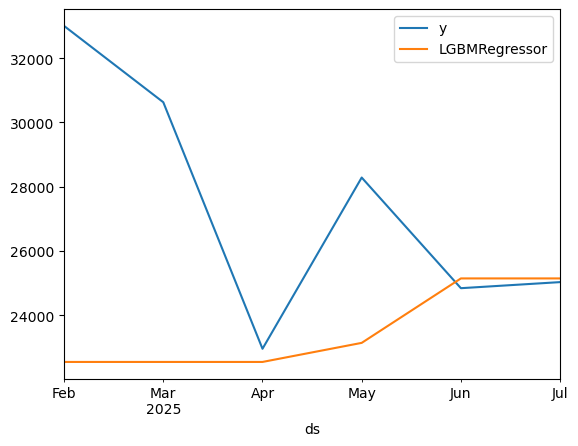

In [114]:
valid.merge(predictions,on=['unique_id','ds']).set_index('ds').plot()

In [9]:
dataset = make_time_features(df_)

In [18]:
import darts.models as m

In [23]:
import darts

In [28]:
import aeon

In [33]:
from aeon.forecasting import RecursiveTabularForecaster

ImportError: cannot import name 'RecursiveTabularForecaster' from 'aeon.forecasting' (c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\aeon\forecasting\__init__.py)

In [32]:
RegressionForecaster??

Init signature: RegressionForecaster(window: int, horizon: int = 1, regressor=None)
Source:        
class RegressionForecaster(
    BaseForecaster, DirectForecastingMixin, IterativeForecastingMixin
):
    """
    Regression based forecasting.

    Container for forecaster that reduces forecasting to regression through a
    window. Form a collection of sub-series of length ``window`` through a sliding
    window to form training collection ``X``, take ``horizon`` points ahead to form
    ``y``, then apply an aeon or sklearn regressor.

    If exogenous variables are provided, they are concatenated with the main series
    and included in the regression windows.

    Parameters
    ----------
    window : int
        The window prior to the current time point to use in forecasting. So if
        horizon is one, forecaster will train using points $i$ to $window+i-1$ to
        predict value $window+i$. If horizon is 4, forecaster will used points $i$
        to $window+i-1$ to predict va

In [10]:
dataset

,unique_id,y,mes,year
ds,,,,
2023-02-01,total,20292.0,2,2023
2023-03-01,total,20389.0,3,2023
2023-04-01,total,19887.0,4,2023
2023-05-01,total,17204.0,5,2023
2023-06-01,total,19006.0,6,2023
2023-07-01,total,24550.0,7,2023
2023-08-01,total,29959.0,8,2023
2023-09-01,total,32075.0,9,2023
2023-10-01,total,30297.0,10,2023


In [10]:
import sktime

In [11]:
from sktime.split import temporal_train_test_split

In [12]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y=dataset.y, X=dataset[['mes','year','lag1','lag6','lag12']], test_size=6)

In [13]:
X_train

,mes,year,lag1,lag6,lag12
ds,,,,,
2023-02-01,2,2023,NaN,NaN,NaN
2023-03-01,3,2023,20292.0,NaN,NaN
2023-04-01,4,2023,20389.0,NaN,NaN
2023-05-01,5,2023,19887.0,NaN,NaN
2023-06-01,6,2023,17204.0,NaN,NaN
2023-07-01,7,2023,19006.0,NaN,NaN
2023-08-01,8,2023,24550.0,20292.0,NaN
2023-09-01,9,2023,29959.0,20389.0,NaN
2023-10-01,10,2023,32075.0,19887.0,NaN


In [14]:
X_test

,mes,year,lag1,lag6,lag12
ds,,,,,
2025-02-01,2,2025,28980.0,22876.0,14388.0
2025-03-01,3,2025,33005.0,25538.0,19034.0
2025-04-01,4,2025,30630.0,20621.0,24471.0
2025-05-01,5,2025,22956.0,27623.0,24893.0
2025-06-01,6,2025,28286.0,51994.0,26681.0
2025-07-01,7,2025,24842.0,28980.0,21151.0


In [15]:
dataset

,unique_id,y,mes,year,lag1,lag6,lag12
ds,,,,,,,
2023-02-01,total,20292.0,2,2023,NaN,NaN,NaN
2023-03-01,total,20389.0,3,2023,20292.0,NaN,NaN
2023-04-01,total,19887.0,4,2023,20389.0,NaN,NaN
2023-05-01,total,17204.0,5,2023,19887.0,NaN,NaN
2023-06-01,total,19006.0,6,2023,17204.0,NaN,NaN
2023-07-01,total,24550.0,7,2023,19006.0,NaN,NaN
2023-08-01,total,29959.0,8,2023,24550.0,20292.0,NaN
2023-09-01,total,32075.0,9,2023,29959.0,20389.0,NaN
2023-10-01,total,30297.0,10,2023,32075.0,19887.0,NaN


In [16]:
training_data  = lgbm.Dataset(X_train, label = y_train,
                        free_raw_data = False)

In [17]:
training_data

In [18]:
params = {
    "objective": "poisson",           # ótimo para vendas/contagens
    "metric": "rmse",
    "learning_rate": 0.03,            # bom valor conservador
    "num_iterations": 500,            # 300–600 é o máximo seguro com poucos dados
    "num_leaves": 16,                 # MÁXIMO 16–24 com <150 linhas! (128 = overfit garantido)
    "max_depth": 5,                   # limita profundidade (evita árvores gigantes)
    "min_data_in_leaf": 6,            # era 100 → impossível com poucos dados! 5–10 é realista
    "min_sum_hessian_in_leaf": 1,     # padrão ok
    "feature_fraction": 0.8,          # colsample_bytree
    "bagging_fraction": 0.8,          # subsample
    "bagging_freq": 1,
    "lambda_l2": 1.0,                 # aumentei um pouco → mais regularização
    "lambda_l1": 0.5,                 # L1 também ajuda com features ruins
    "verbosity": -1,
    "seed": 42,
    "force_row_wise": True,
}
# Train LightGBM model
m_lgb = lgbm.train(params, training_data)

In [19]:
def prever_recursivo_lgb(model, ultima_linha, n_meses=24):
    linha = ultima_linha.copy()
    previsoes = []
    
    for _ in range(n_meses):
        pred = model.predict(linha,predict_disable_shape_check=True)[0]
        previsoes.append(pred)
        
        # Atualiza lags recursivamente
        linha['lag1'] = pred
        linha['lag6'] = linha['lag1'].shift(5).fillna(linha['lag6']).iloc[0]
        linha['lag12'] = linha['lag1'].shift(11).fillna(linha['lag12']).iloc[0]
        
        # Atualiza mes/ano
        nova_data = linha.index[0] + pd.DateOffset(months=1)
        linha.index = [nova_data]
        linha['mes'] = nova_data.month
        linha['year'] = nova_data.year
        
        # Atualiza features derivadas (se tiver)
        if 'media_12m' in linha.columns:
            linha['media_12m'] = linha['lag1'].rolling(12).mean().iloc[-1]
    
    datas = pd.date_range(start=ultima_linha.index[0] + pd.DateOffset(months=1),
                          periods=n_meses, freq='MS')
    return pd.Series(previsoes, index=datas)

# Uso
ultima_linha = X_train.iloc[[-1]].copy()
forecast = prever_recursivo_lgb(m_lgb, ultima_linha, n_meses=6)

print(forecast.round(0))
#print(f"MAPE nos 18 meses de teste: {mean_absolute_percentage_error(y_test, previsao_24_meses.iloc[:18]):.2%}")

2025-02-01    25538.0
2025-03-01    21480.0
2025-04-01    20639.0
2025-05-01    19684.0
2025-06-01    19595.0
2025-07-01    19595.0
Freq: MS, dtype: float64


In [20]:
pd.concat(pd.DataFrame(y_test),pd.DataFrame(forecast,columns=['yhat']))

TypeError: concat() takes 1 positional argument but 2 were given

In [21]:
y_test

ds
2025-02-01    33005.0
2025-03-01    30630.0
2025-04-01    22956.0
2025-05-01    28286.0
2025-06-01    24842.0
2025-07-01    25031.0
Name: y, dtype: float64

In [320]:
m_lgb.predict(X_test.iloc[0])

c:\Users\eduar\AppData\Local\anaconda3\envs\or-env\lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


array([22995.67542515])

In [ ]:
reg = xgb.XGBRegressor(n_estimators=500,early_stopping_rounds=50,learning_rate=0.1)
reg.fit(X_train,y_train
        #,eval_set=[(X_train,y_train),(X_test,y_test)]
        ,verbose=100
        )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [298]:
pd.DataFrame(reg.predict(X_train))

,0
0,20291.996094
1,20388.980469
2,19887.003906
3,17204.019531
4,19006.003906
5,24549.980469
6,29958.992188
7,32075.005859
8,30297.011719
9,38603.988281


In [ ]:
25671
25671
25671
25671
25671
26097
26666
26666
26666
27941
127941
125671
125671
125671
126237
126237
126365
126059
126059
126307
226097
226412
227941
226666

In [283]:
X_test.iloc[0]

mes          2.0
year      2025.0
lag1     28980.0
lag6     22876.0
lag12    14388.0
Name: 2025-02-01 00:00:00, dtype: float64

In [302]:
reg.predict(X_test.iloc[0])

ValueError: feature_names mismatch: ['mes', 'year', 'lag1', 'lag6', 'lag12'] ['2025-02-01 00:00:00']
expected lag1, mes, lag12, year, lag6 in input data
training data did not have the following fields: 2025-02-01 00:00:00

In [273]:
X_test.iloc[0]

mes          2.0
year      2025.0
lag1     28980.0
lag6     22876.0
lag12    14388.0
Name: 2025-02-01 00:00:00, dtype: float64

In [257]:
def prever_proximos_meses_correto(model, ultimo_df_conhecido, n_meses=12):
    """
    ultimo_df_conhecido = as últimas linhas do seu X_train (pelo menos 14 linhas!)
    """
    # Garante que temos histórico suficiente
    historico = ultimo_df_conhecido.copy()
    previsoes = []
    
    for i in range(n_meses):
        # Pega a última linha conhecida (a mais recente)
        ultima_linha = historico.iloc[[-1]].copy()
        
        # Próxima data
        proxima_data = ultima_linha.index[0] + pd.DateOffset(months=1)
        ultima_linha.index = [proxima_data]
        
        # Atualiza mes e ano
        ultima_linha['mes'] = proxima_data.month
        ultima_linha['year'] = proxima_data.year
        
        # FAZ A PREVISÃO
        y_pred = model.predict(ultima_linha)[0]
        previsoes.append(y_pred)
        
        # === RECURSÃO: adiciona a previsão como nova linha no histórico ===
        nova_linha = ultima_linha.copy()
        # Aqui é o segredo: os lags antigos já estão corretos!
        # Só precisamos inserir a previsão como o novo "vendas" (não tem coluna vendas, mas não precisa)
        # Basta adicionar a linha nova no histórico → os .shift() vão fazer mágica no próximo passo
        
        historico = pd.concat([historico, nova_linha])
    
    # Datas corretas
    datas_futuras = pd.date_range(
        start=ultimo_df_conhecido.index[-1] + pd.DateOffset(months=1),
        periods=n_meses, freq='MS'
    )
    return pd.Series(previsoes, index=datas_futuras)

# Pega as últimas 14+ linhas do treino (pra ter lag_14)
ultimo_historico = X_train.tail(20).copy()     # 20 é mais que suficiente

previsao = prever_proximos_meses_correto(reg, ultimo_historico, n_meses=12)

print(previsao.round(0))



2025-02-01    26667.0
2025-03-01    26667.0
2025-04-01    26667.0
2025-05-01    26667.0
2025-06-01    26667.0
2025-07-01    26667.0
2025-08-01    26667.0
2025-09-01    26667.0
2025-10-01    26667.0
2025-11-01    27942.0
2025-12-01    27942.0
2026-01-01    26667.0
Freq: MS, dtype: float32


In [250]:
previsao

2025-02-01    26666.802734
2025-03-01    26666.802734
2025-04-01    26666.802734
2025-05-01    26666.802734
2025-06-01    26666.802734
2025-07-01    26666.802734
Freq: MS, dtype: float32

In [242]:
reg.predict(X_train)[0]

np.float32(25671.518)

In [228]:
reg.predict(X_test[1:2])

array([26237.361], dtype=float32)

In [186]:
X_train.columns

Index(['mes', 'year', 'lag1', 'lag6', 'lag12'], dtype='object')

In [187]:
pd.DataFrame(data=reg.feature_importances_,index = X_train.columns,columns=['importance'])

,importance
mes,0.497433
year,0.001338
lag1,0.084645
lag6,0.257417
lag12,0.159167


In [197]:
X_train.index[-1]

Timestamp('2025-01-01 00:00:00')

In [210]:
def make_future_step_a_head(X_train):
    # Depois d
    # o fit
    last_date = X_train.index[-1]

    # Cria as próximas 6 datas mensais (Month Start = dia 1)
    next_date = last_date + pd.DateOffset(months=1)
    d_1 = pd.DataFrame(index=[next_date])
    d_1['mes'] = next_date.month
    d_1['year'] = next_date.year

    return pd.concat([X_train, d_1])


In [211]:
make_future_step_a_head(X_train)

,mes,year,lag1,lag6,lag12
2023-02-01,2,2023,NaN,NaN,NaN
2023-03-01,3,2023,20292.0,NaN,NaN
2023-04-01,4,2023,20389.0,NaN,NaN
2023-05-01,5,2023,19887.0,NaN,NaN
2023-06-01,6,2023,17204.0,NaN,NaN
2023-07-01,7,2023,19006.0,NaN,NaN
2023-08-01,8,2023,24550.0,20292.0,NaN
2023-09-01,9,2023,29959.0,20389.0,NaN
2023-10-01,10,2023,32075.0,19887.0,NaN
2023-11-01,11,2023,30297.0,17204.0,NaN


In [192]:
future_dates

DatetimeIndex(['2025-02-01'], dtype='datetime64[ns]', freq='MS')

In [188]:
prediction = pd.DataFrame(y_test)
prediction['yhat'] = reg.predict(X_test)

In [189]:
X_test

,mes,year,lag1,lag6,lag12
ds,,,,,
2025-02-01,2,2025,28980.0,22876.0,14388.0
2025-03-01,3,2025,33005.0,25538.0,19034.0
2025-04-01,4,2025,30630.0,20621.0,24471.0
2025-05-01,5,2025,22956.0,27623.0,24893.0
2025-06-01,6,2025,28286.0,51994.0,26681.0
2025-07-01,7,2025,24842.0,28980.0,21151.0


<Axes: xlabel='ds'>

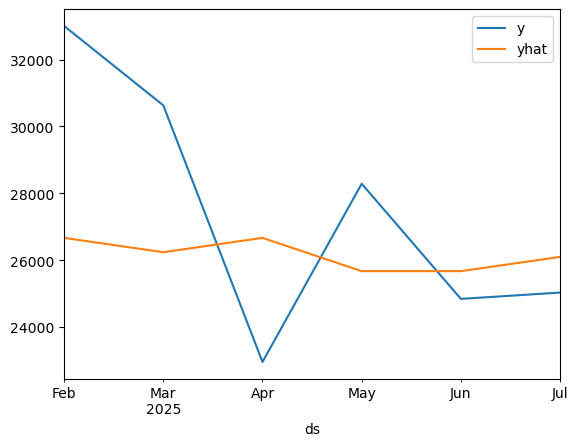

In [190]:
prediction.plot()

In [175]:
y_test

ds
2025-02-01 00:00:00                                              33005.0
2025-03-01 00:00:00                                              30630.0
2025-04-01 00:00:00                                              22956.0
2025-05-01 00:00:00                                              28286.0
2025-06-01 00:00:00                                              24842.0
2025-07-01 00:00:00                                              25031.0
y_hat                  [26666.803, 26237.361, 26666.803, 25671.518, 2...
Name: y, dtype: object

In [ ]:
estimator=LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=31)

In [160]:
forecaster = RecursiveTimeSeriesRegressionForecaster(
    estimator=LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=31),
    window_length=6,      # 7 dias de histórico como features
)

# Depois do fit
last_date = y_train.index[-1]

# Cria as próximas 6 datas mensais (Month Start = dia 1)
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(months=1),
    periods=6,
    freq='MS'          # MS = Month Start (dia 1 de cada mês)
)

forecaster.fit(y=y_train, X=X_train.index)

# Previsão (sem precisar de X futuro se você não tem exógenas!)
y_pred = forecaster.predict(fh=fh)

TypeError: Unsupported input data type in RecursiveTimeSeriesRegressionForecaster, input X must be in an sktime compatible format. Allowed scitypes for X in forecasting are None, Series, Panel, Hierarchical, for instance a pandas.DataFrame with sktime compatible time indices, or with MultiIndex and last(-1) level an sktime compatible time index. See the forecasting tutorial examples/01_forecasting.ipynb, or the data format tutorial examples/AA_datatypes_and_datasets.ipynb See the data format tutorial examples/AA_datatypes_and_datasets.ipynb. If you think the data is already in an sktime supported input format, run sktime.datatypes.check_raise(data, mtype) to diagnose the error, where mtype is the string of the type specification you want. Error message for checked mtypes, in format [mtype: message], as follows: [dask_hierarchical: X must be of python type dask.dataframe, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [pd_multiindex_hier: X must be of python type pandas.DataFrame, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [dask_panel: X must be of python type dask.dataframe, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [df-list: X must be of python type list, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [gluonts_ListDataset_panel: X must be of python type list, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [nested_univ: X must be of python type pandas.DataFrame, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [numpy3D: X must be of python type numpy.ndarray, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [pd-multiindex: X must be of python type pandas.DataFrame, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [dask_series: X must be of python type dask.dataframe, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [np.ndarray: X must be of python type numpy.ndarray, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [pd.DataFrame: X must be of python type pandas.DataFrame, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [pd.Series: X must be of python type pandas.Series, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>]  [xr.DataArray: X must be of python type xarray.DataArray, or a subtype thereof, but found <class 'pandas.core.indexes.datetimes.DatetimeIndex'>] 

In [147]:
# Horizonte de 7 dias à frente (168 horas)
fh = ForecastingHorizon(future,freq='M')

In [149]:
forecaster.fit(y=y_train, X=X_train)

ValueError: Found array with dim 3. LGBMRegressor expected <= 2.

In [80]:
fh

ForecastingHorizon(['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06',
             '2025-07', '2025-08', '2025-09', '2025-10',
             ...
             '2038-03', '2038-04', '2038-05', '2038-06', '2038-07', '2038-08',
             '2038-09', '2038-10', '2038-11', '2038-12'],
            dtype='period[M]', length=168, is_relative=False)

In [69]:
RecursiveTimeSeriesRegressionForecaster()

Init signature:
RecursiveTimeSeriesRegressionForecaster(
    estimator,
    window_length=10,
    transformers=None,
    pooling='local',
)
Source:        
class RecursiveTimeSeriesRegressionForecaster(_RecursiveReducer):
    """Recursive reduction from forecasting to time series regression.

    For the recursive strategy, a single estimator is fit for a one-step-ahead
    forecasting horizon and then called iteratively to predict multiple steps ahead.

    Parameters
    ----------
    estimator : Estimator
        A time-series regression estimator as provided by sktime.
    window_length : int, optional (default=10)
        The length of the sliding window used to transform the series into
        a tabular matrix.
    """

    _tags = {
        "requires-fh-in-fit": False,  # is the forecasting horizon required in fit?
    }

    _estimator_scitype = "time-series-regressor"
File:           c:\users\eduar\appdata\local\anaconda3\envs\or-env\lib\site-packages\sktime\forecasting\comp

In [50]:
from aeon.forecasting.model_selection

SyntaxError: invalid syntax (1672641410.py, line 1)

In [ ]:
from sklearn.model_selection import train_test_split

In [46]:
train_test_split(dataset,test_size=6)

[           unique_id        y  mes  year     lag1     lag6    lag12
 ds                                                                 
 2023-03-01     total  20389.0    3  2023  20292.0      NaN      NaN
 2025-07-01     total  25031.0    7  2025  24842.0  28980.0  21151.0
 2024-11-01     total  27623.0   11  2024  20621.0  24893.0  38604.0
 2025-01-01     total  28980.0    1  2025  51994.0  21151.0  19663.0
 2024-04-01     total  24471.0    4  2024  19034.0  30297.0  19887.0
 2024-03-01     total  19034.0    3  2024  14388.0  32075.0  20389.0
 2024-01-01     total  19663.0    1  2024  52187.0  24550.0      NaN
 2025-03-01     total  30630.0    3  2025  33005.0  25538.0  19034.0
 2025-04-01     total  22956.0    4  2025  30630.0  20621.0  24471.0
 2023-10-01     total  30297.0   10  2023  32075.0  19887.0      NaN
 2024-12-01     total  51994.0   12  2024  27623.0  26681.0  52187.0
 2024-07-01     total  21151.0    7  2024  26681.0  19663.0  24550.0
 2023-08-01     total  29959.0    

In [ ]:
import aeon.segmentation


aeon.segmentation?

In [41]:
aeon.utils?

Type:        module
String form: <module 'aeon.utils' from 'c:\\Users\\eduar\\AppData\\Local\\anaconda3\\envs\\or-env\\lib\\site-packages\\aeon\\utils\\__init__.py'>
File:        c:\users\eduar\appdata\local\anaconda3\envs\or-env\lib\site-packages\aeon\utils\__init__.py
Docstring:   Utility functionality.

In [ ]:
import aeon.


aeon.datasets

In [38]:
aeon.segmentation??

Type:        module
String form: <module 'aeon.segmentation' from 'c:\\Users\\eduar\\AppData\\Local\\anaconda3\\envs\\or-env\\lib\\site-packages\\aeon\\segmentation\\__init__.py'>
File:        c:\users\eduar\appdata\local\anaconda3\envs\or-env\lib\site-packages\aeon\segmentation\__init__.py
Source:     
"""Time Series Segmentation."""

__all__ = [
    "BaseSegmenter",
    "BinSegmenter",
    "FLUSSSegmenter",
    "ClaSPSegmenter",
    "find_dominant_window_sizes",
    "GreedyGaussianSegmenter",
    "InformationGainSegmenter",
    "entropy",
    "RandomSegmenter",
    "EAggloSegmenter",
    "HMMSegmenter",
    "HidalgoSegmenter",
]

from aeon.segmentation._binseg import BinSegmenter
from aeon.segmentation._clasp import ClaSPSegmenter, find_dominant_window_sizes
from aeon.segmentation._eagglo import EAggloSegmenter
from aeon.segmentation._fluss import FLUSSSegmenter
from aeon.segmentation._ggs import GreedyGaussianSegmenter
from aeon.segmentation._hidalgo import HidalgoSegmenter
from aeo

In [ ]:
afrom aeon.segmentation import traina

In [23]:
df_.set_index('ds').

,unique_id,y
ds,,
2023-02-01,total,20292.0
2023-03-01,total,20389.0
2023-04-01,total,19887.0
2023-05-01,total,17204.0
2023-06-01,total,19006.0
2023-07-01,total,24550.0
2023-08-01,total,29959.0
2023-09-01,total,32075.0
2023-10-01,total,30297.0


In [19]:
df_.a

,unique_id,ds,y
0,total,2023-02-01,20292.0
1,total,2023-03-01,20389.0
2,total,2023-04-01,19887.0
3,total,2023-05-01,17204.0
4,total,2023-06-01,19006.0
5,total,2023-07-01,24550.0
6,total,2023-08-01,29959.0
7,total,2023-09-01,32075.0
8,total,2023-10-01,30297.0
9,total,2023-11-01,38604.0
